DEMO




#### First: Individual Satisfied Curve
Acquire sample data


In [0]:
import pandas as pd
from google.colab import drive
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
from math import exp

%matplotlib inline

In [0]:
# prepare google sheet integration: install package
!pip install --upgrade --quiet gspread

# Import the library, authenticate, and create the interface to Sheets.
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
#read sheet
sh = gc.open('Occupant Data')
worksheet = sh.worksheet("Demo")

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
sample_data = pd.DataFrame.from_records(rows)
sample_data = sample_data.drop([10,11], axis=1)
sample_data.columns = sample_data.iloc[0]
sample_data = sample_data.drop(sample_data.index[0])
sample_data_sex = pd.get_dummies(sample_data['Sex'])
sample_data = pd.concat([sample_data, sample_data_sex], axis=1)
sample_data = sample_data.drop(['Sex'], axis=1)

# Extract the sample data and convert to ndarray 
sample_data_np = sample_data.to_numpy()
sample_data_np = sample_data_np[0:,1:]
sample_data_np = sample_data_np.astype('float64')
sample_data

,,Age,Height,Weight,Clothing Level,Metabolism,Outdoor Monthly Air Temperature,Relative Humidity,Air Velocity,f,m
1,Occupant 1,48,168,80,0.5,1,28,54,0.11,0,1
2,Occupant 2,25,164,55,0.6,1,28,54,0.11,1,0
3,Occupant 3,28,170,58,0.5,1,28,54,0.11,0,1
4,Occupant 4,23,167,60,0.5,1,28,54,0.11,1,0
5,Occupant 5,26,168,65,0.5,1,28,54,0.11,1,0
6,Occupant 6,35,185,105,0.5,1,28,54,0.11,0,1
7,Occupant 7,34,155,58,0.5,1,28,54,0.11,0,1
8,Occupant 8,31,168,58,0.5,1,28,54,0.11,0,1
9,Occupant 9,36,180,88,0.5,1,28,54,0.11,0,1
10,Occupant 10,22,160,63,0.5,1,28,54,0.11,1,0


In [0]:
worksheet = sh.worksheet("co")
rows = worksheet.get_all_values()
co0 = pd.DataFrame.from_records(rows)
co = co0.to_numpy()
co = co.astype('float64')
co = co.T
worksheet = sh.worksheet("intr")
rows = worksheet.get_all_values()
intr0 = pd.DataFrame.from_records(rows)
intr = intr0.to_numpy()
intr = intr.astype('float64')

In [0]:
# Fit the sample data into our model; compute temperature aT^2+bT+c coefficiencets (a,b,c)
para_num = 11
n = len(sample_data_np)
coeff = np.zeros([n,3])

for i in range(n):
    coeff[i,0] = co[0,para_num]
    coeff[i,1] = co[0,0] + np.sum(co[0,(para_num+1):2*para_num]*sample_data_np[i,:])
    coeff[i,2] = np.sum(co[0,1:para_num]*sample_data_np[i,:]) + intr
    k = 2*para_num
    for j in range(1,para_num):
        coeff[i,2] += np.sum(co[0,k:(k+para_num-j)]*sample_data_np[i,(j-1):]*sample_data_np[i,j-1])
        k += para_num-j

print(coeff)
para = pd.DataFrame(data=coeff[0:,0:])
para = para.rename(columns={0: "a", 1: "b", 2: "c"})


[[ -0.0206435    0.91780894  -9.43540912]
 [ -0.0206435    1.07547158 -13.419279  ]
 [ -0.0206435    1.03983406 -11.7826645 ]
 [ -0.0206435    1.09535777 -14.08028551]
 [ -0.0206435    1.08353912 -13.9348152 ]
 [ -0.0206435    1.04866485 -13.10865208]
 [ -0.0206435    0.91394002  -9.04508567]
 [ -0.0206435    1.01458635 -11.20789699]
 [ -0.0206435    1.03480274 -12.41246744]
 [ -0.0206435    1.0469426  -13.07005607]
 [ -0.0206435    1.10305153 -13.526777  ]
 [ -0.0206435    1.06449891 -12.7945661 ]
 [ -0.0206435    1.08220849 -13.29750942]
 [ -0.0206435    1.04674657 -12.13760865]
 [ -0.0206435    1.06941389 -12.85522762]]


In [0]:
# Compute individual satisfaction probability: S = 1/(1+exp(Temperature Equation))
t1 = 0 
t2 = 38
Temp = np.linspace(t1,t2,num=2*t2+1)
S_snew= np.zeros([n,len(Temp)])

# Generate the Satisfaction Probability for each individual
S= np.zeros([n,len(Temp)])
for j in range(n):
  for i in range(len(Temp)):
    S[j,i] = 1/(1+exp(-(Temp[i]*Temp[i]*coeff[j,0]+coeff[j,1]*Temp[i]+coeff[j,2])))
# S[0:2,:]

# def an annotation function
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "x={:.1f}, y={:.2f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.8,0.85), **kw)


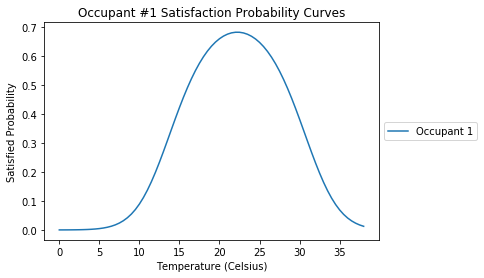

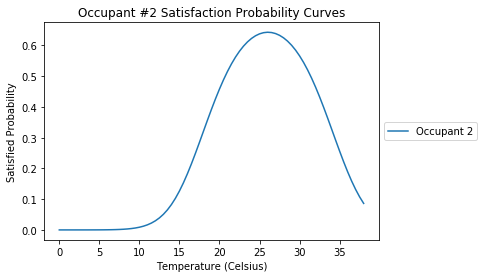

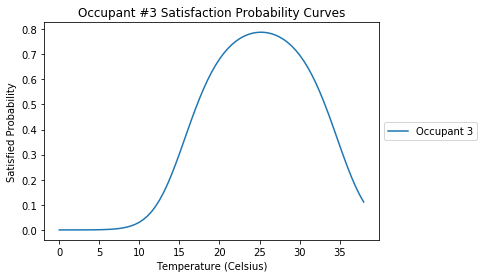

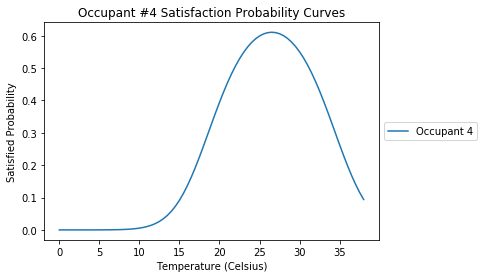

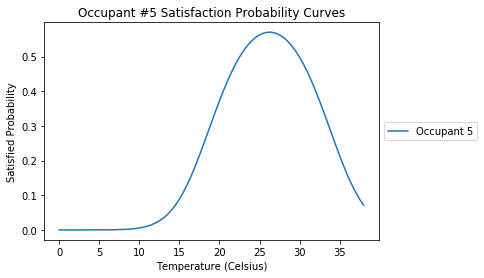

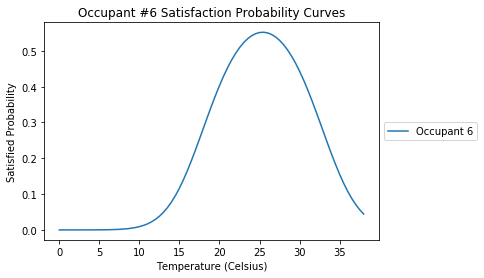

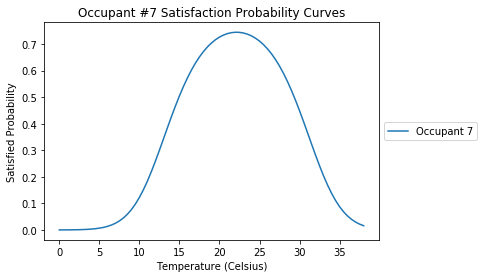

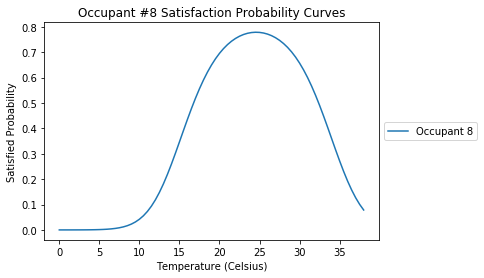

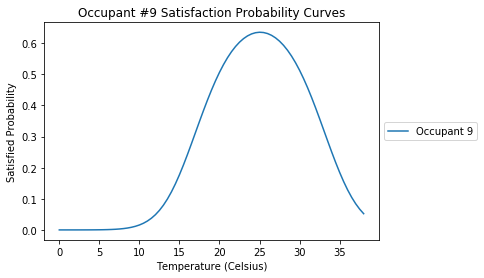

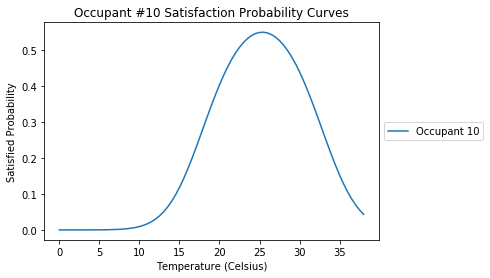

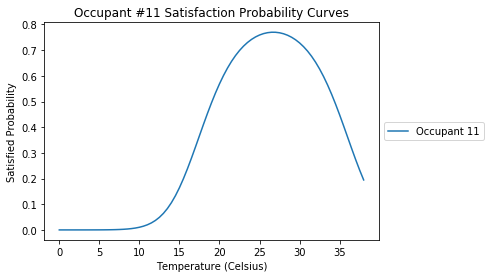

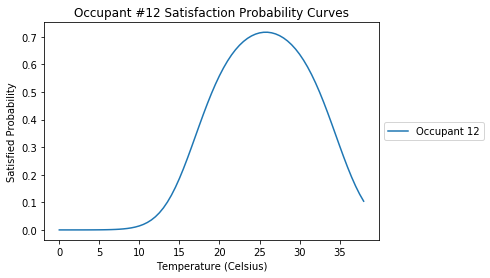

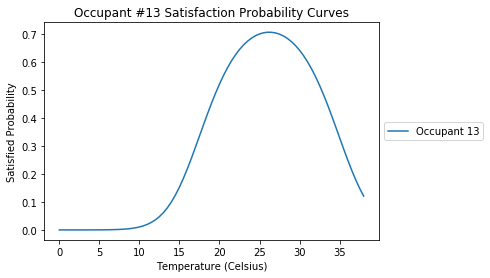

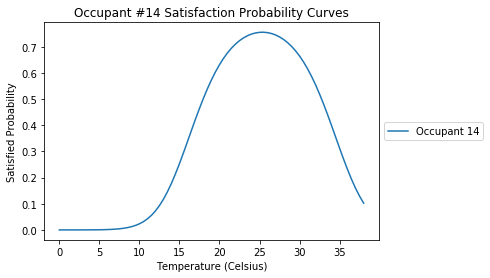

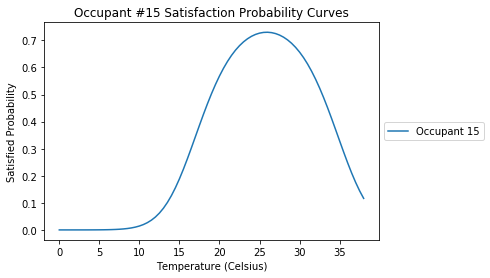

In [0]:
# in one graph
for i in range(n):
  I = i+1
  plt.plot(Temp,S[i],label ="Occupant %i" %I)
  plt.xlabel('Temperature (Celsius)') 
  plt.ylabel('Satisfied Probability')
  #plt.title('%i Occupants Satisfaction Probability Curves' %n)
  plt.title('Occupant #%i Satisfaction Probability Curves' %I)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show() 

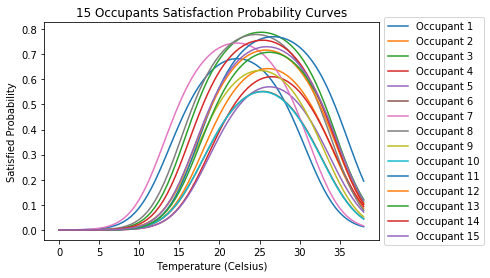

In [0]:
# in one graph
for i in range(n):
  I = i+1
  plt.plot(Temp,S[i],label ="Occupant %i" %I)
  plt.xlabel('Temperature (Celsius)') 
  plt.ylabel('Satisfied Probability')
  plt.title('%i Occupants Satisfaction Probability Curves' %n)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show() 

### Group Best Temp - Method 1: Most satisfied 



Text(0.8, 0.65, "('25.500000', '0.674523')")

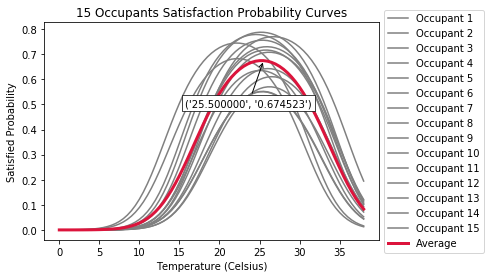

In [0]:
# Calculate Group Satisfaction Probability S
Group_S = np.zeros([len(Temp),1])
for i in range(len(Temp)):
  Group_S[i,0]= np.mean(S[:,i])

# Plot the graph
x=Temp
y=Group_S
xmax = x[np.argmax(y)]
ymax = max(y)
ymax = ymax.astype(np.float)
xmax = xmax.astype(np.float)
text= ('%f' %xmax, '%f' %ymax)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="->",connectionstyle="arc3")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")

S2 = np.concatenate([S,Group_S.T],0)
for i in range(n+1):
    I = i+1
    if i == n:
      plt.plot(Temp,S2[i], linewidth = 3, color = "crimson", label ='Average')
    else:
      plt.plot(Temp,S2[i], color = "grey", label ="Occupant %i" %I)
    plt.xlabel('Temperature (Celsius)') 
    plt.ylabel('Satisfied Probability')
    plt.title('%i Occupants Satisfaction Probability Curves' %n)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.annotate(text, xy=(xmax, ymax), xytext=(0.8,0.65), **kw)

# plt.show() 

In [0]:
## authenticate prupose 

# Import the library, authenticate, and create the interface to Sheets.
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

#read sheet
sh = gc.open('Occupant Data')
worksheet = sh.worksheet("Demo")
worksheet.update_acell('K2', xmax)


{'spreadsheetId': '1L0L5tnjElA4-LYvy9MMnrXBTo6LaUouq-EygE4tCg5Q',
 'updatedCells': 1,
 'updatedColumns': 1,
 'updatedRange': 'Demo!K2',
 'updatedRows': 1}

#### Group Best Temp - Method 2: Least Complaint

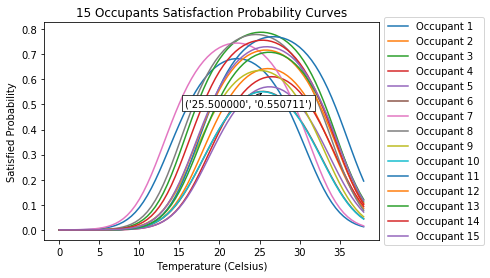

25.5


In [0]:
# Method 2 Least Complaint 

# S_min = np.zeros([n,1])
# for i in range(n):
#   S_min[i] = max(S[i])
# best_group_temp = Temp[np.argmax(S[np.argmin(S_min)])]

S_min = np.zeros([len(Temp),1])
for i in range(len(Temp)):
  S_min[i] = min(S[:,i])
best_group_temp = Temp[np.argmax(S_min)]
xmax = best_group_temp
ymax = max(S_min)

ymax = ymax.astype(np.float)
xmax = xmax.astype(np.float)
text= ('%f' %xmax, '%f' %ymax)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="->",connectionstyle="arc3")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")

for i in range(n):
  I = i+1
  plt.plot(Temp,S[i],label ="Occupant %i" %I)
  plt.xlabel('Temperature (Celsius)') 
  plt.ylabel('Satisfied Probability')
  plt.title('%i Occupants Satisfaction Probability Curves' %n)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.annotate(text, xy=(best_group_temp, ymax), xytext=(0.8,0.65), **kw)  
plt.show() 


## authenticate purpose
# Import the library, authenticate, and create the interface to Sheets.
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

#read sheet
sh = gc.open('Occupant Data')
worksheet = sh.worksheet("Demo")
worksheet.update_acell('L2', best_group_temp)
print(best_group_temp)